In [13]:
from utilities import *
from plot_utilities import *

np.random.seed(42)

In [14]:
# Note that the code below assumes you are in the "testing-framework" directory. Can check Current Working Directory below:
# Should be testing-framework
os.getcwd()

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'

In [15]:
''' Only need to run commented code once '''
# data_dict = pd.read_pickle('../data/Panoptic Agriculture/Transformed Dataset/Panoptic_Data_Dict_Normalized.pickle')
# obs_x_dict = dict()
# for layer in np.arange(2, 9):
#     obs_x_dict[layer] = create_obs_x(data_dict, layer)
# pd.to_pickle(obs_x_dict, 'panoptic/obs_x_dict.pickle')

obs_x_dict = pd.read_pickle('panoptic/obs_x_dict.pickle') # Already sorted
obs_x_dict

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

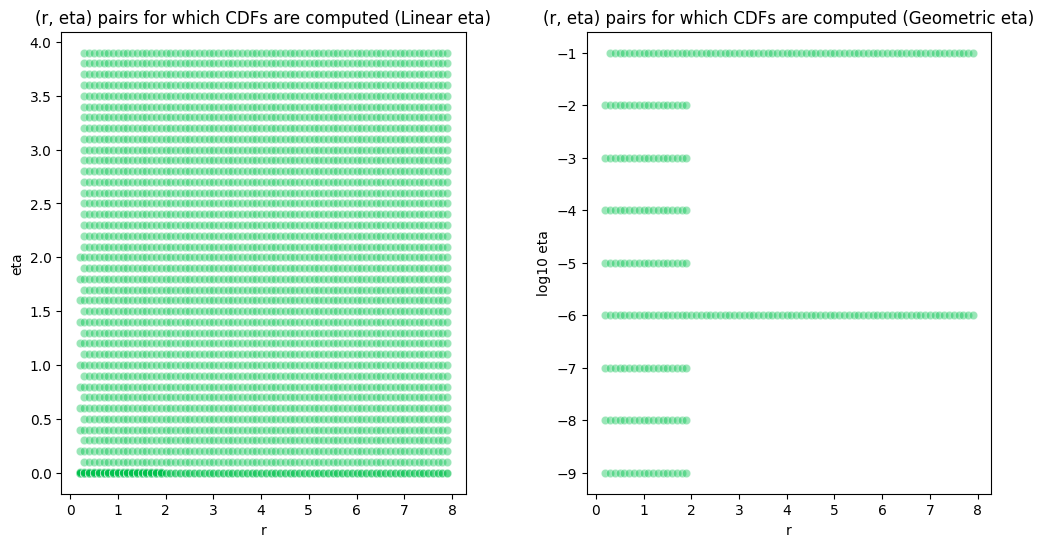

In [16]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)
all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') 
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

In [17]:
''' Only need to run commented code once'''
# master_df = pd.DataFrame(columns = ['layer', 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
# idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
# sorted_params = sorted(all_cdfs)
# for i, layer in enumerate(np.arange(2, 9)):
#     sample = obs_x_dict[layer]
#     ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
#     ksstats_eta0 = [ksstats[i] for i in idx_eta0]
#     idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
#     master_df.loc[i, :] = [layer, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
# master_df = master_df.set_index('layer')
# master_df.to_csv(f'panoptic/CSVs/initial_eta0_grid.csv')

master_df = pd.read_csv(f'panoptic/CSVs/initial_eta0_grid.csv', index_col='layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0
layer,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259


Best parameters (0.6, 3.2) with KS-test Statistic 0.0383 and pvalue 0.0001693037457256742, layer 2 with num_samples=3180


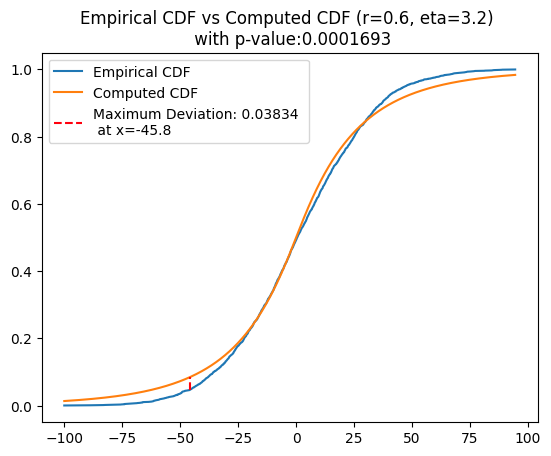

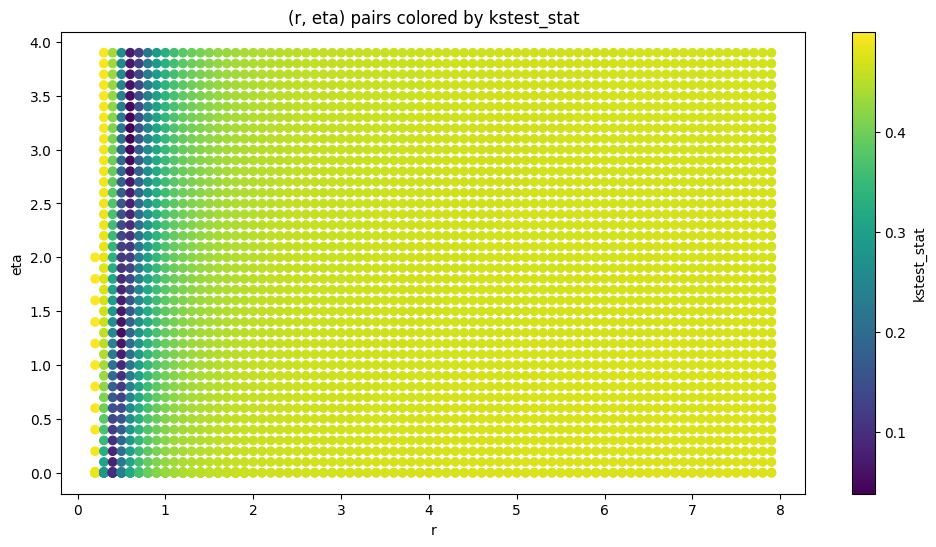

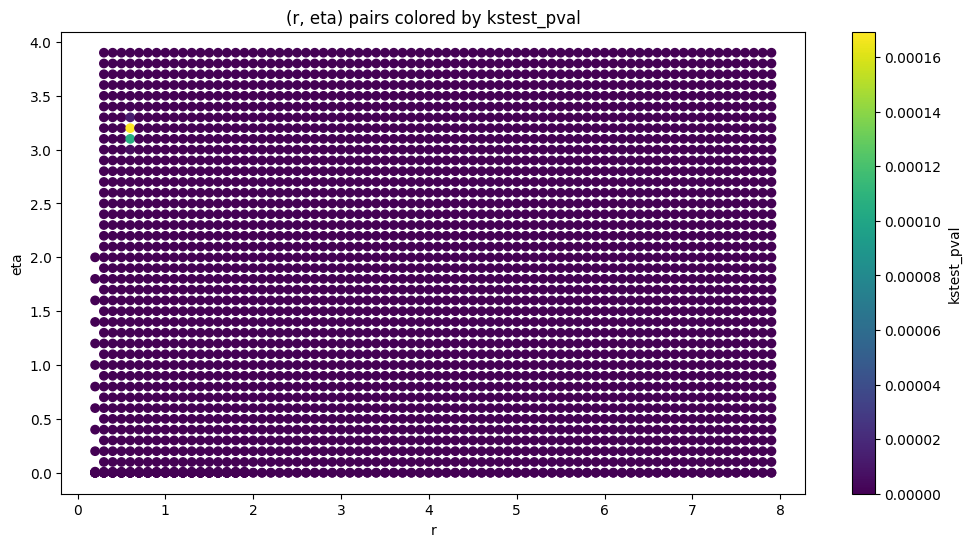

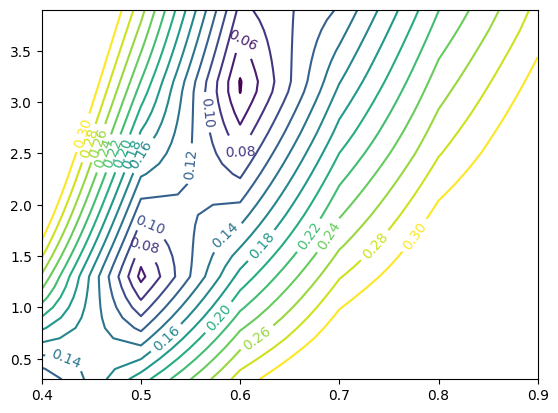

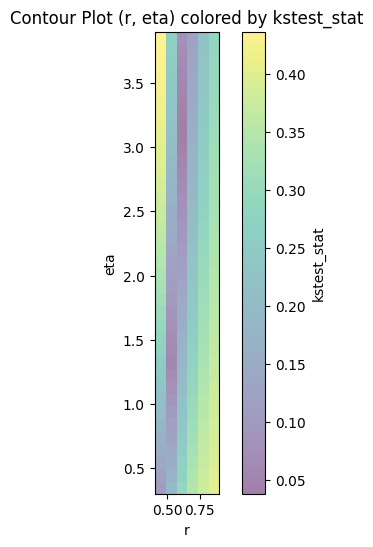

In [18]:
# Experimental cell displaying some plots

layer = 2
obs_x = obs_x_dict[layer]
all_ksstats, initial_param, min_stat = gridsearch(obs_x, all_cdfs)
df = all_cdfs_df.copy()
total_samples = obs_x.size
df['kstest_stat'] = all_ksstats
df['kstest_pval'] = stats.kstwo(n=total_samples).sf(all_ksstats)
print(f"Best parameters {(initial_param)} with KS-test Statistic {np.round(min_stat, 4)} and pvalue {stats.kstwo(n=total_samples).sf(min_stat)}, layer {layer} with num_samples={total_samples}")
distance, location = visualize_cdf(obs_x, initial_param[0], initial_param[1], 10000, all_cdfs)
create_scatter_plot(df, 'kstest_stat')
create_scatter_plot(df, 'kstest_pval')

df0 = df[(df['r'] > 0.3) & (df['eta'] >= 0.3) & (df['r'] < 1)]
indices = df0.index
x = np.array(df0['r'].loc[indices])
y = np.array(df0['eta'].loc[indices])
z = np.array(df0['kstest_stat'].loc[indices]) 
X, Y = np.meshgrid(df0['r'].unique(), df0['eta'].unique())

dims_r = df0['r'].unique().size
dims_eta = df0['eta'].unique().size
fig, ax = plt.subplots()
CS = ax.contour(x.reshape(dims_r, dims_eta), y.reshape(dims_r, dims_eta), z.reshape(dims_r, dims_eta), np.append(np.arange(0.04, 0.3, 0.02), 0.3), cmap =  'viridis')
ax.clabel(CS, CS.levels, inline=True, fontsize=10)
create_contour_plot(df0,'kstest_stat')

In [19]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for layer in np.arange(2, 9):
    num_points = obs_x_dict[layer].size
    master_df.loc[layer, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0,kstest_stat_cutoff_0.05
layer,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.024030
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.012029
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.006018
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.003010
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,0.001505
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,0.000753
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,0.000376


In [59]:
# r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized

# for layer in np.arange(2, 9): 
#     sample = obs_x_dict[layer]
#     initial_param = master_df.loc[layer, 'initial_param']
#     master_df.loc[layer, f'best_r_d{r_d}'], master_df.loc[layer, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, r_depth = r_d, eta_depth=eta_d, layer=layer)
#     master_df.loc[layer, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'layer{layer}_10000')[(master_df.loc[layer, f'best_r_d{r_d}'], master_df.loc[layer, f'best_eta_d{eta_d}'])])

# master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
# master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'panoptic/CSVs/optimized_params.csv')
master_df = pd.read_csv('panoptic/CSVs/master_df_post_optimize.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0,kstest_stat_cutoff_0.05,best_r_d3,best_eta_d2,kstest_stat_cd,n_pval_0.05
layer,,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.024030,0.602,3.20,0.036033,1341
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.012029,0.705,3.60,0.019860,4770
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.006018,0.803,3.00,0.010449,16098
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.003010,0.901,1.60,0.003043,203520
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,0.001505,1.030,0.33,0.003707,128142
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,0.000753,4.630,0.00,0.024879,3016
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,0.000376,5.700,0.00,0.171259,60


In [103]:
def visualize_cdf_pdf(sample, params, distro = 'gengamma', log_scale = True, n_samples=10000, all_cdfs=None, layer=None):
    """
    Visualize the gap between the empirical CDF/PDF and the Computed CDF/PDF.

    Args:
        sample (np.ndarray): Observed data.
        r (float): r value.
        eta (float): eta value.
        n_samples (int): Number of samples for the computed CDF/PDF.
        all_cdfs (dict): Dictionary containing computed CDFs.
        layer (int or None): Layer index (for titling purposes).

    Returns:
        distance (float): The Kolmogorov-Smirnov statistic.
        location (float): The location of the maximum deviation between the empirical and computed CDFs.
    """
    xs = np.linspace(np.min(sample), np.max(sample), 10000)
    sample = np.sort(sample)
    n = len(sample)
    
    if distro == 'gengamma':
        r = params[0]
        eta = params[1]
        if all_cdfs and (r, eta) in all_cdfs:
            null_cdf = all_cdfs[(r, eta)]
        else:
            null_cdf = compute_prior_cdf(r=r, eta=eta, n_samples=n_samples)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = scipy.stats.norm(scale=params).cdf
    elif distro == 'laplace':
        null_cdf = scipy.stats.laplace(scale=params).cdf

    if log_scale:

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

        # Empirical CDF vs Computed CDF
        ax1.set_xlim(left = -25, right = 25)
        ax1.plot(sample, np.arange(1, n+1)/n, label='Empirical CDF')
        ax1.plot(xs, null_cdf(xs), label='Computed CDF')
        result = stats.ks_1samp(sample, null_cdf)
        distance = result.statistic
        location = result.statistic_location
        emp_cdf_at_loc = np.searchsorted(sample, location, side='right') / n
        computed_cdf_at_loc = null_cdf(location)
        ax1.vlines(location, emp_cdf_at_loc, computed_cdf_at_loc, linestyles='--', label=f'Maximum Deviation: {np.round(distance, 6)}\nat x={np.round(location, 6)}', color='xkcd:bright red')
        if layer:
            ax1.set_title(f'Layer {layer} Empirical CDF vs Computed CDF \n (r={r}, eta={eta}) with p-value:{np.round(result.pvalue, 8)}')
        else:
            ax1.set_title(f'Empirical CDF vs Computed CDF (r={r}, eta={eta}) \n with p-value:{np.round(result.pvalue, 8)}')
        ax1.legend()

        # Empirical PDF vs Computed PDF
        ax2.set_xlim(left = -25, right = 25)
        xs_pdf, computed_pdf = compute_prior_pdf(r, eta, tail_bound=0.01)
        bw = 0.05
        sns.kdeplot(sample, bw_method = bw, ax=ax2, label='Empirical PDF (KDE, bw={bw})')
        ax2.plot(xs_pdf, computed_pdf, label='Computed PDF')
        if layer:
            ax2.set_title(f'Layer {layer} Empirical PDF vs Computed PDF \n (r={r}, eta={eta})')
        else:
            ax2.set_title(f'Empirical PDF vs Computed PDF (r={r}, eta={eta})')
        ax2.legend()

        # Log Scale
        ax3.set_xlim(left = -25, right = 25)
        ax3.set_ylim(bottom = 10**-4, top=10)
        bw = 0.05
        sns.kdeplot(ax = ax3, x = sample, bw_method = bw, log_scale=[False, True], label = f"Empirical PDF (KDE, bw={bw})")
        ax3.plot(xs_pdf, computed_pdf, label = "Computed PDF")
        if layer:
            ax3.set_title(f'Layer {layer} Log Scale :\n Empirical PDF vs Computed PDF (r={r}, eta={eta})')
        else:
            ax3.set_title(f'Log Scale:\nEmpirical PDF vs Computed PDF (r={r}, eta={eta})')
        ax3.legend()

        plt.tight_layout()
        plt.show()

    else:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Empirical CDF vs Computed CDF
        ax1.plot(sample, np.arange(1, n+1)/n, label='Empirical CDF')
        ax1.plot(xs, null_cdf(xs), label='Computed CDF')
        result = stats.ks_1samp(sample, null_cdf)
        distance = result.statistic
        location = result.statistic_location
        emp_cdf_at_loc = np.searchsorted(sample, location, side='right') / n
        computed_cdf_at_loc = null_cdf(location)
        ax1.vlines(location, emp_cdf_at_loc, computed_cdf_at_loc, linestyles='--', label=f'Maximum Deviation: {np.round(distance, 6)}\nat x={np.round(location, 6)}', color='xkcd:bright red')
        if layer:
            ax1.set_title(f'Layer {layer} Empirical CDF vs Computed CDF \n (r={r}, eta={eta}) with p-value:{np.round(result.pvalue, 8)}')
        else:
            ax1.set_title(f'Empirical CDF vs Computed CDF (r={r}, eta={eta}) \n with p-value:{np.round(result.pvalue, 8)}')
        ax1.legend()

        # Empirical PDF vs Computed PDF
        xs_pdf, computed_pdf = compute_prior_pdf(r, eta)
        sns.kdeplot(sample, ax=ax2, label='Empirical PDF (KDE)')
        ax2.plot(xs_pdf, computed_pdf, label='Computed PDF')
        if layer:
            ax2.set_title(f'Layer {layer} Empirical PDF vs Computed PDF \n (r={r}, eta={eta})')
        else:
            ax2.set_title(f'Empirical PDF vs Computed PDF (r={r}, eta={eta})')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return fig

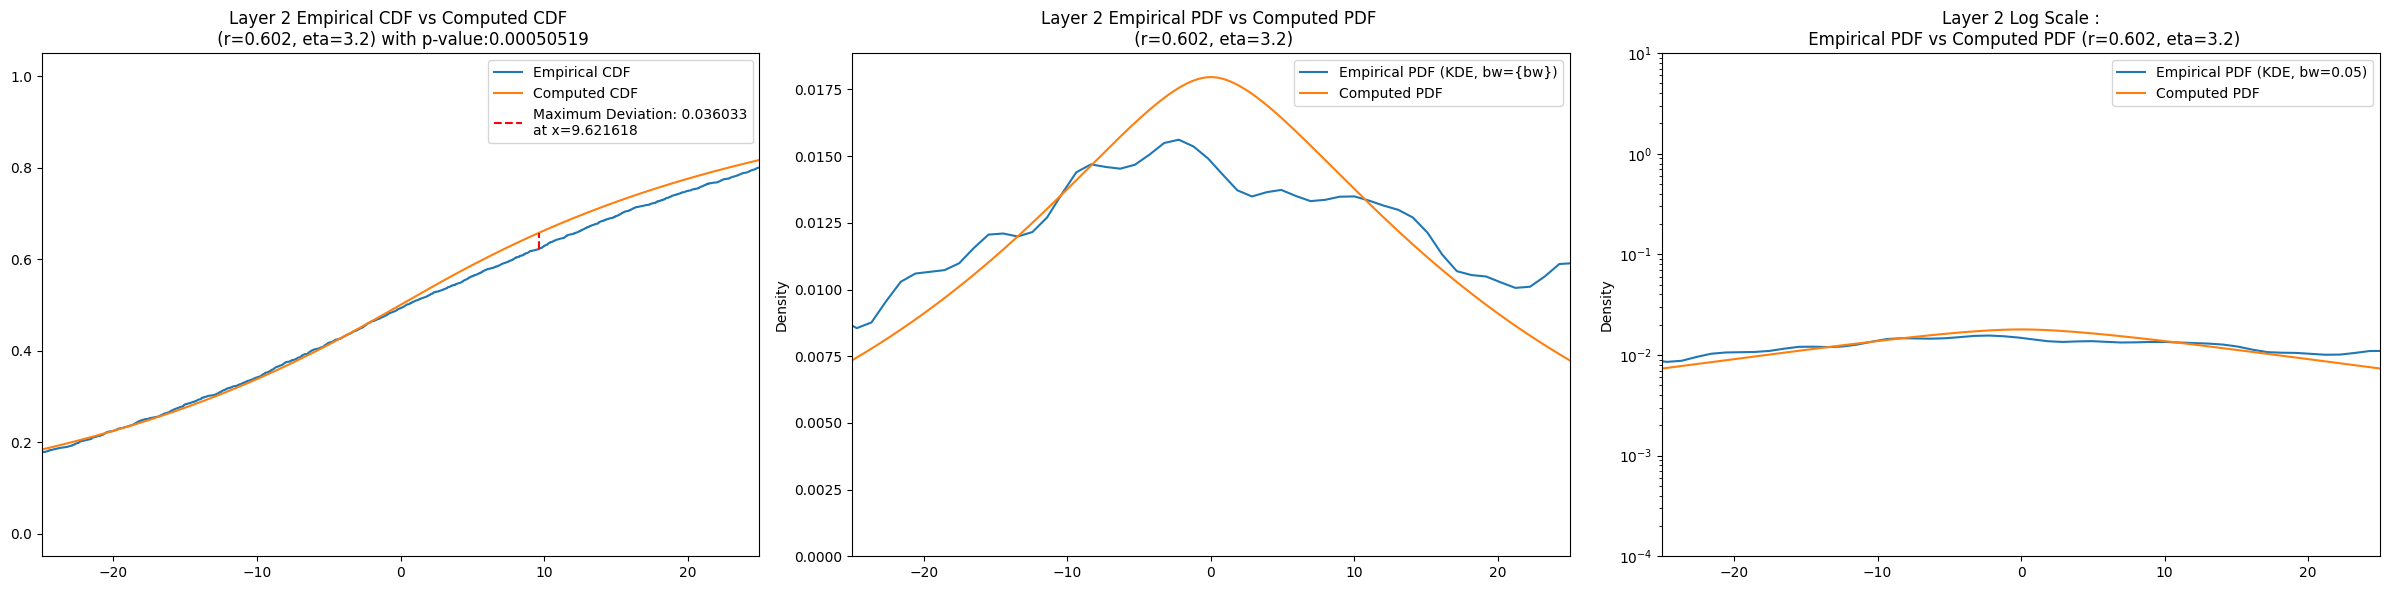

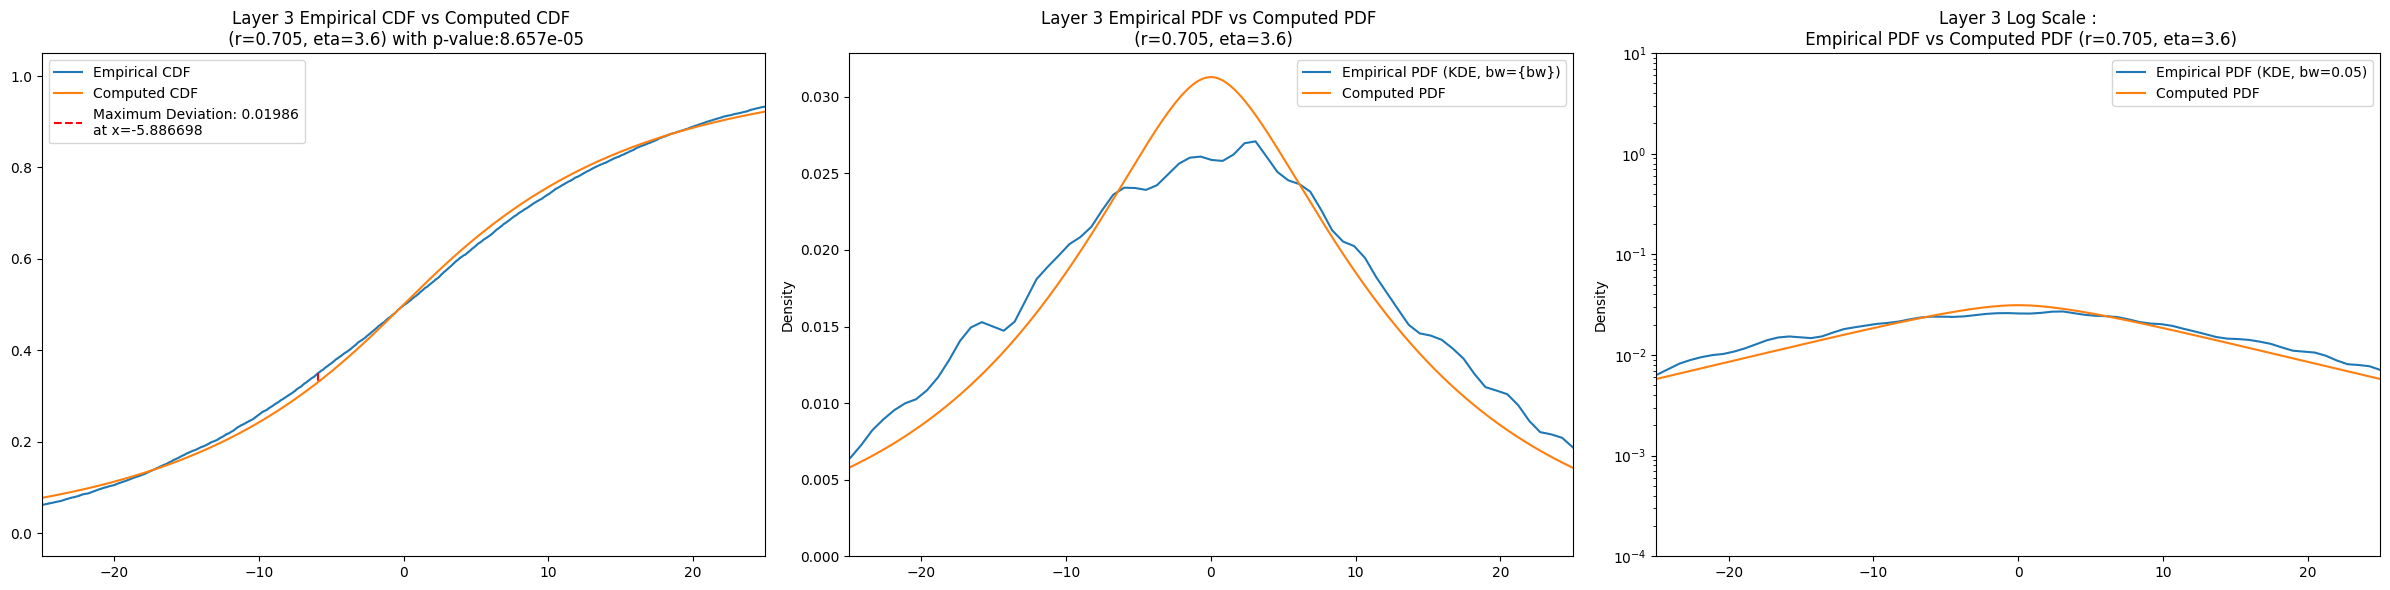

No Tail


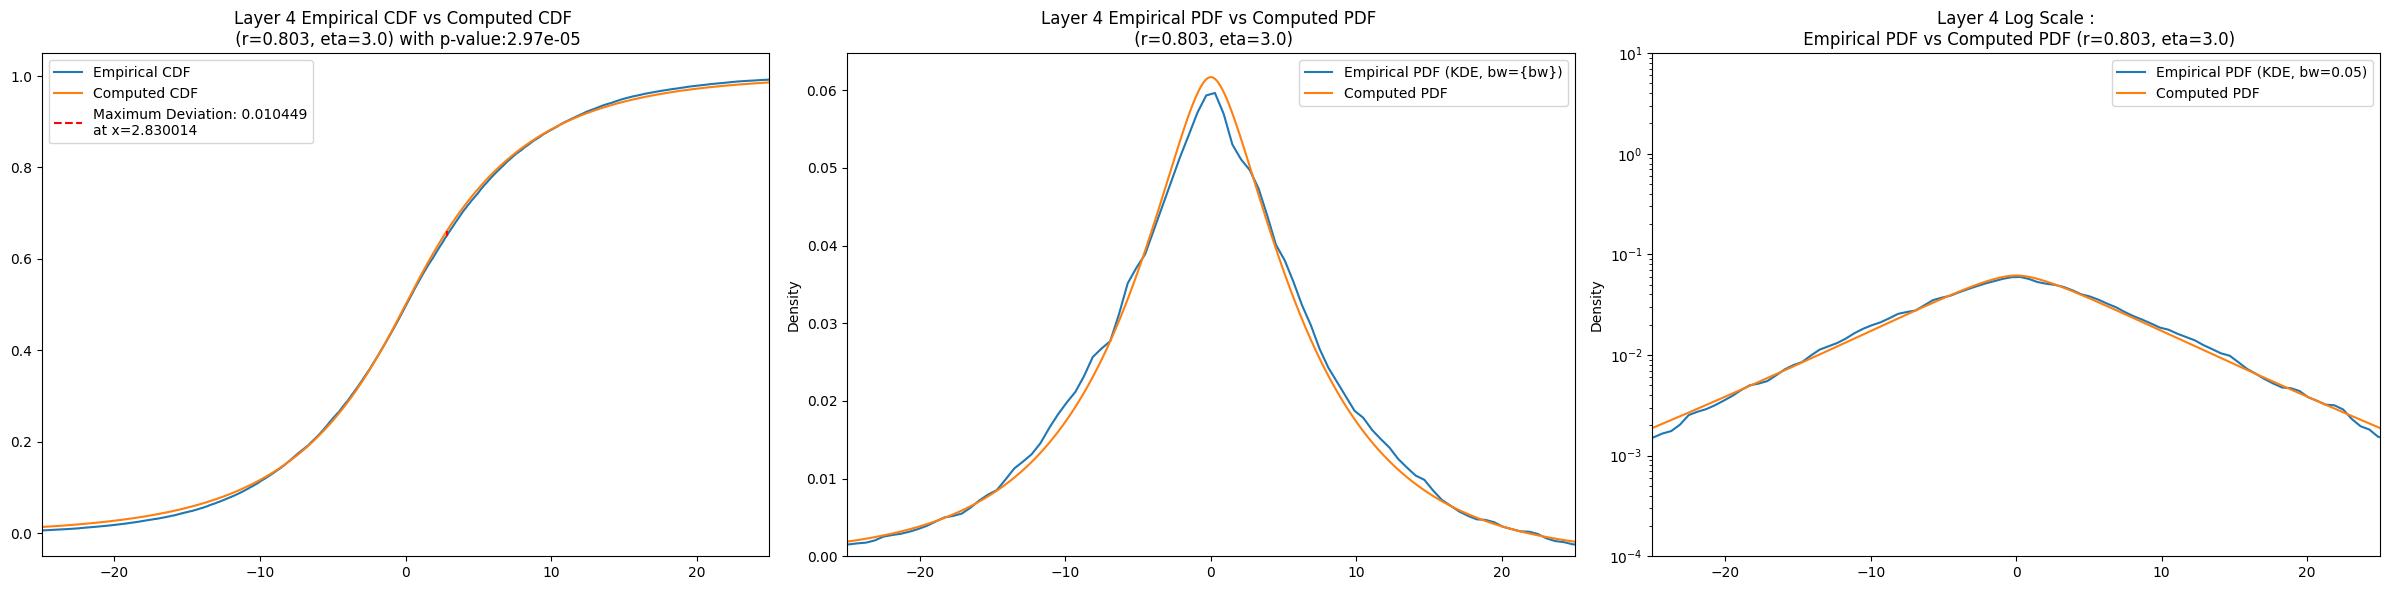

No Tail


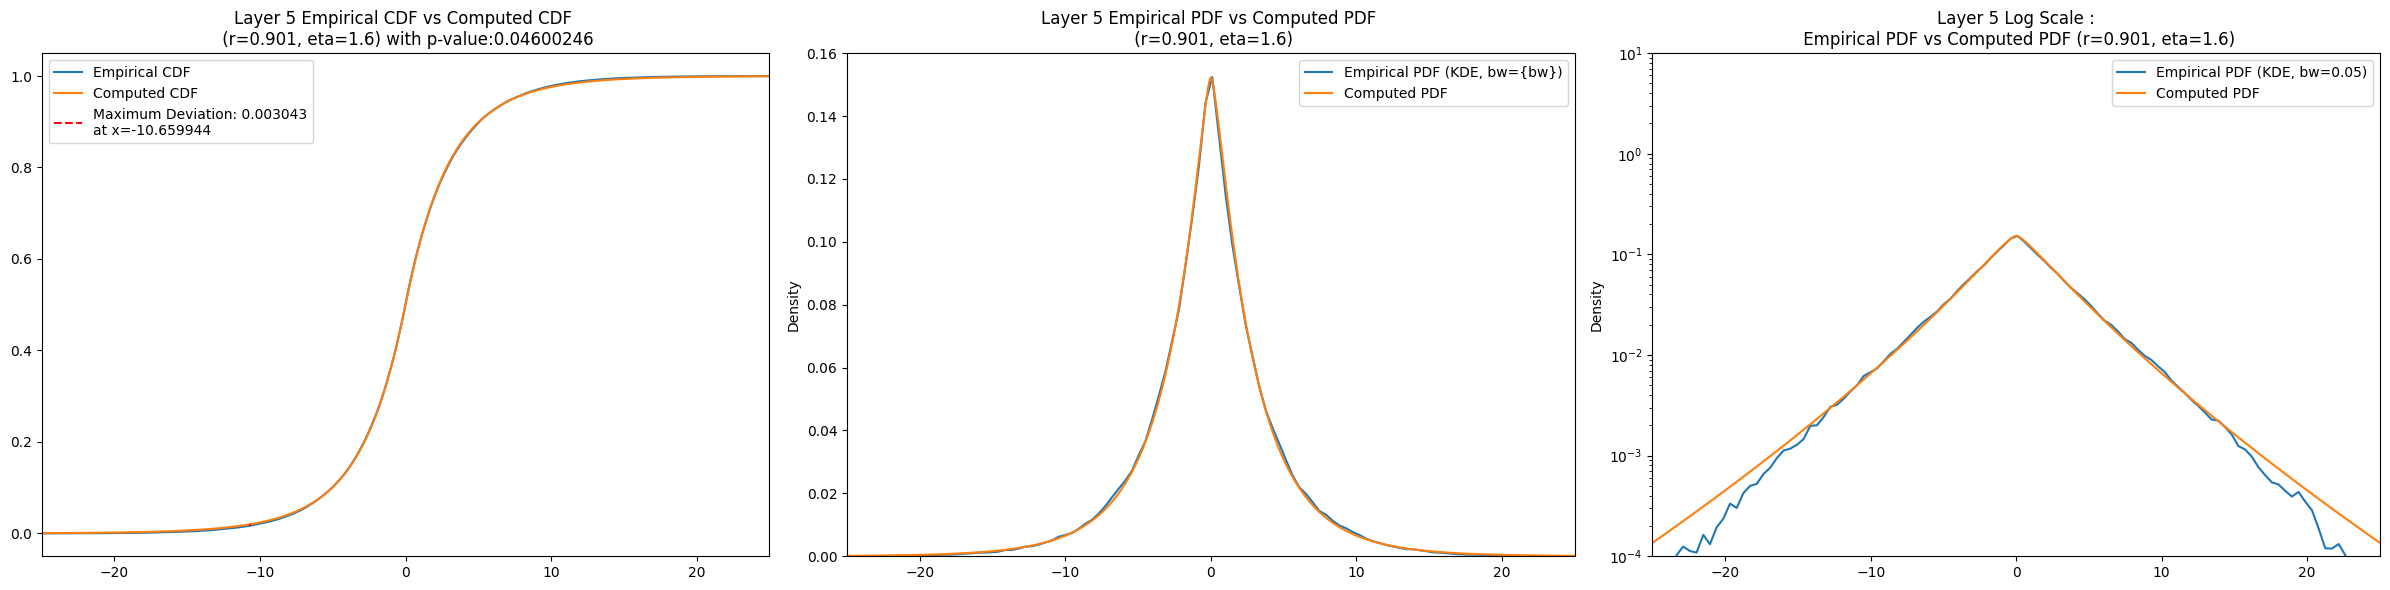

No Tail


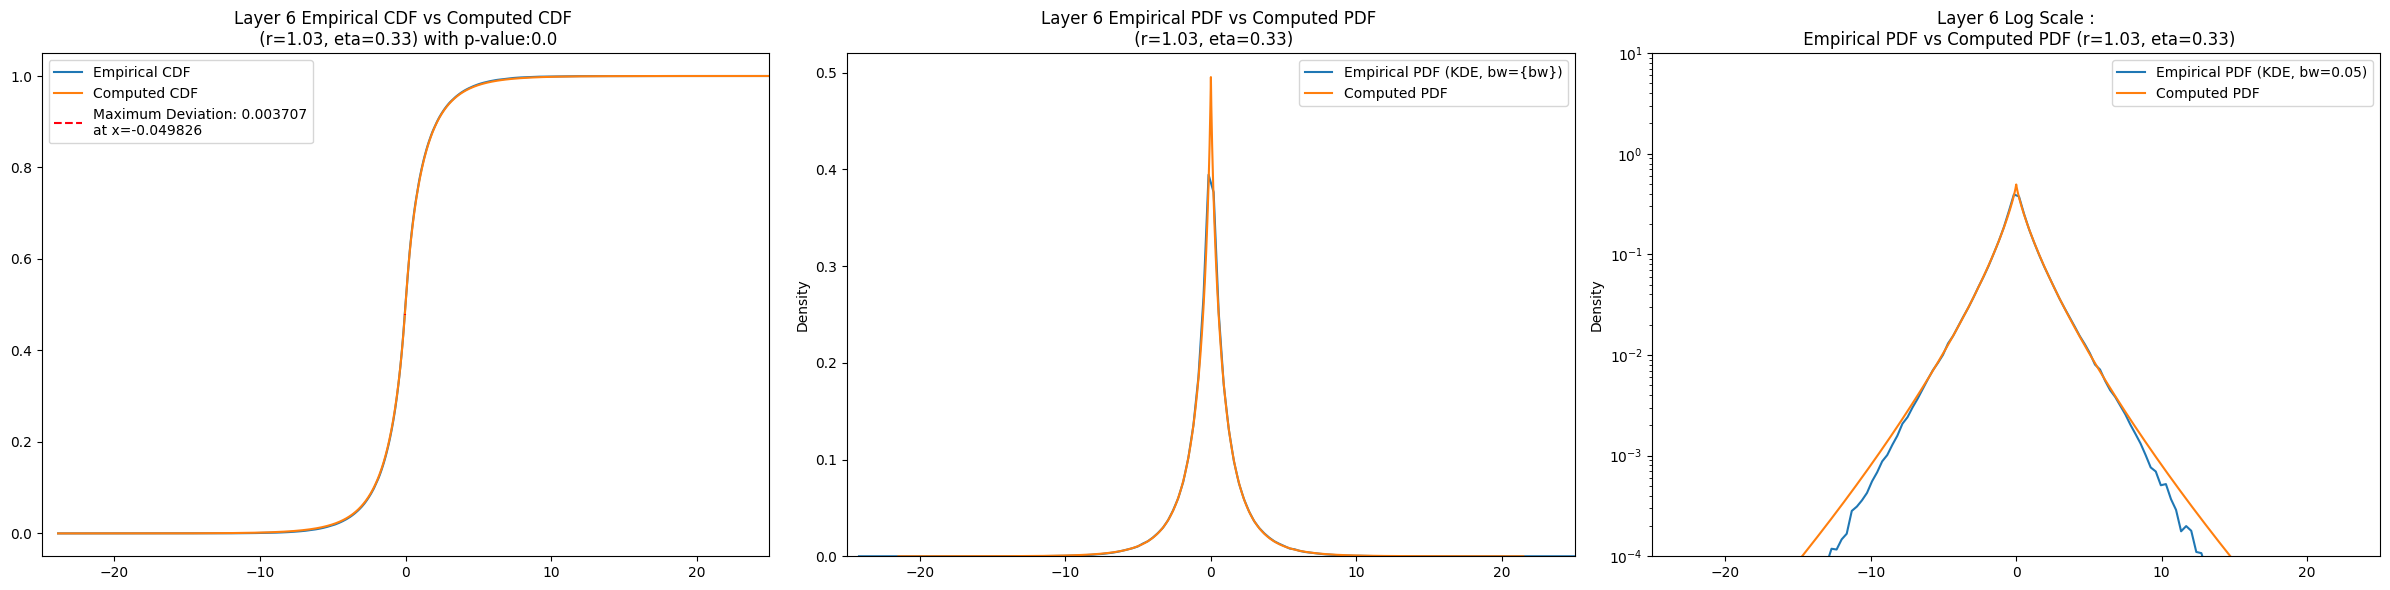

No Tail


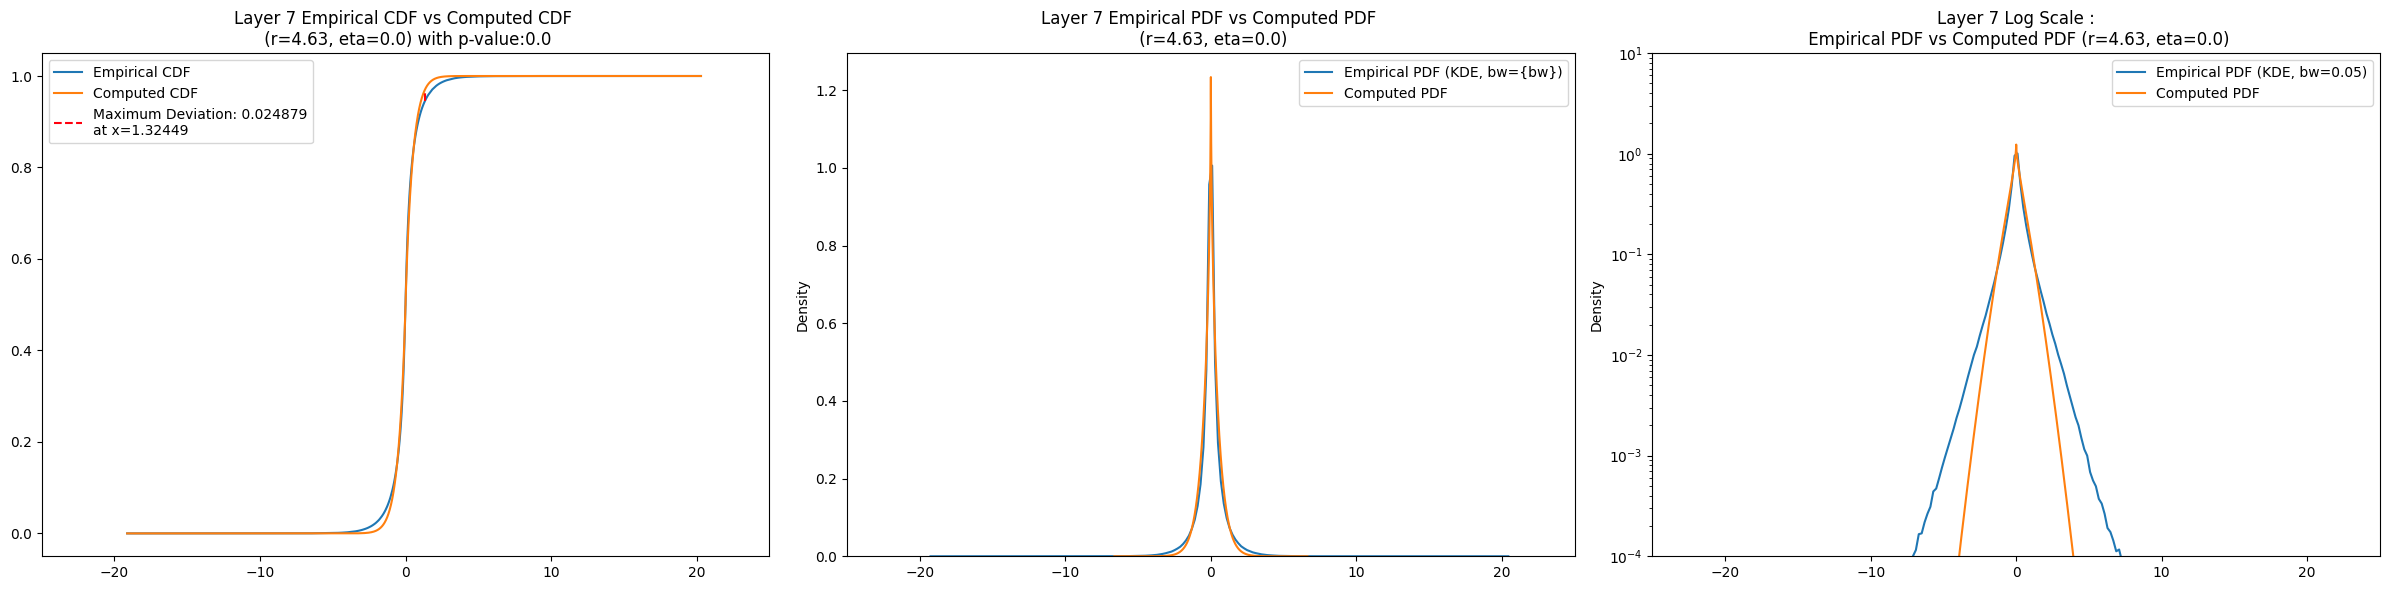

No Tail


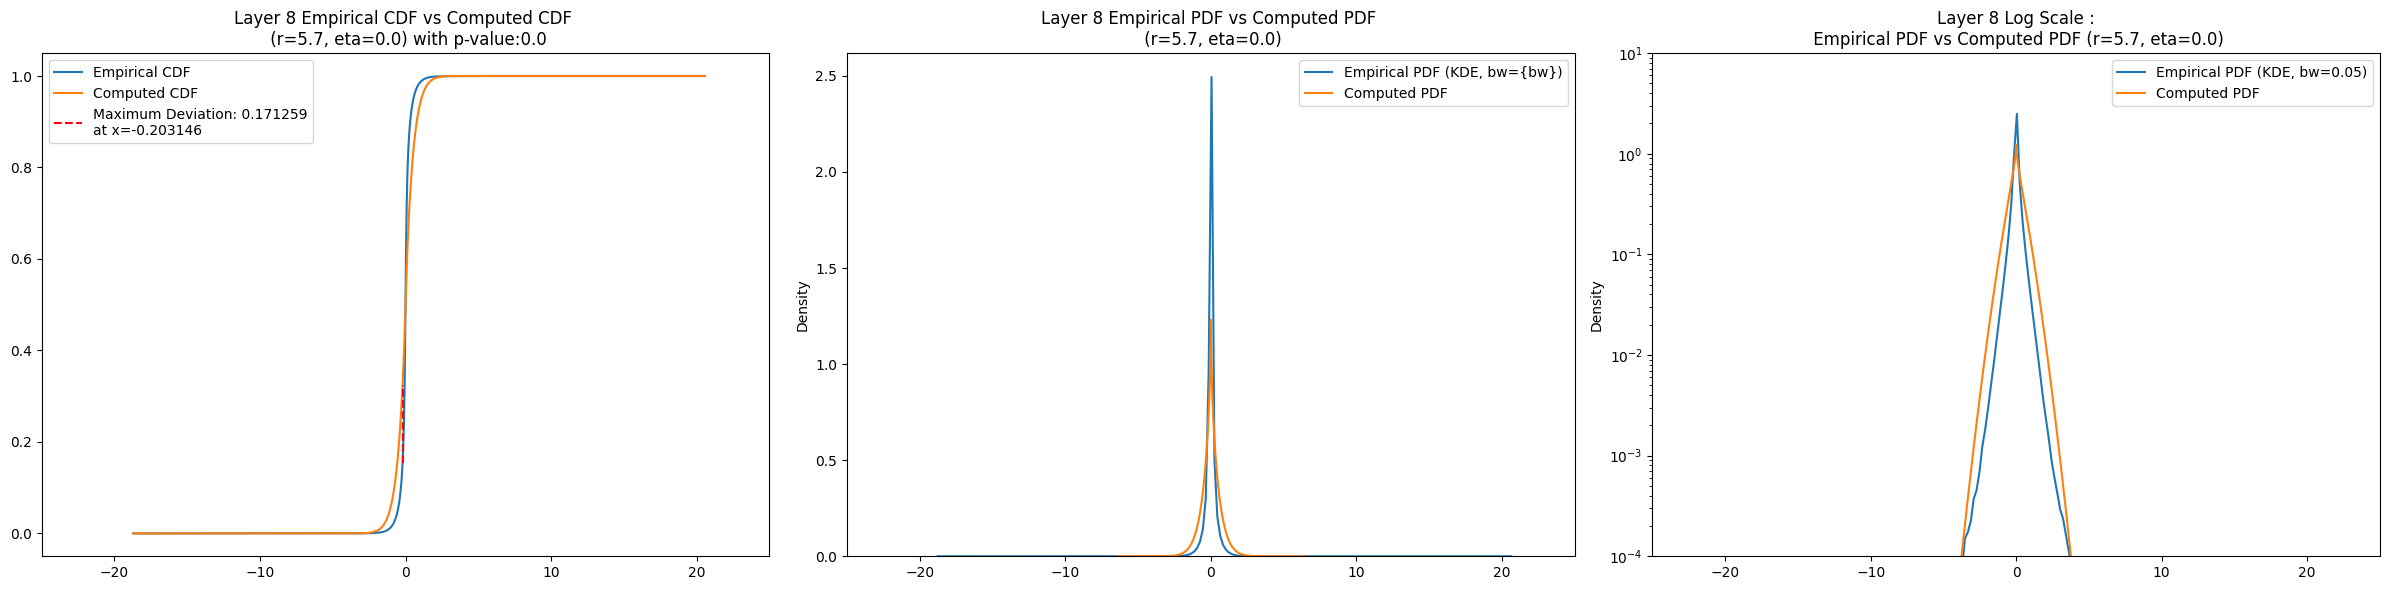

In [104]:
for layer in np.arange(2, 9):
    layer_info = master_df.loc[layer]
    fig = visualize_cdf_pdf(obs_x_dict[layer], 
                      params = (layer_info[f'best_r_d{r_d}'], layer_info[f'best_eta_d{eta_d}']), 
                      log_scale = True,
                      all_cdfs = combine_pickles(f'layer{layer}_10000'),
                      layer = layer)
    fig.savefig(f'panoptic/plots/compare_cdf_pdf_layer_{layer}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

No Tail
No Tail


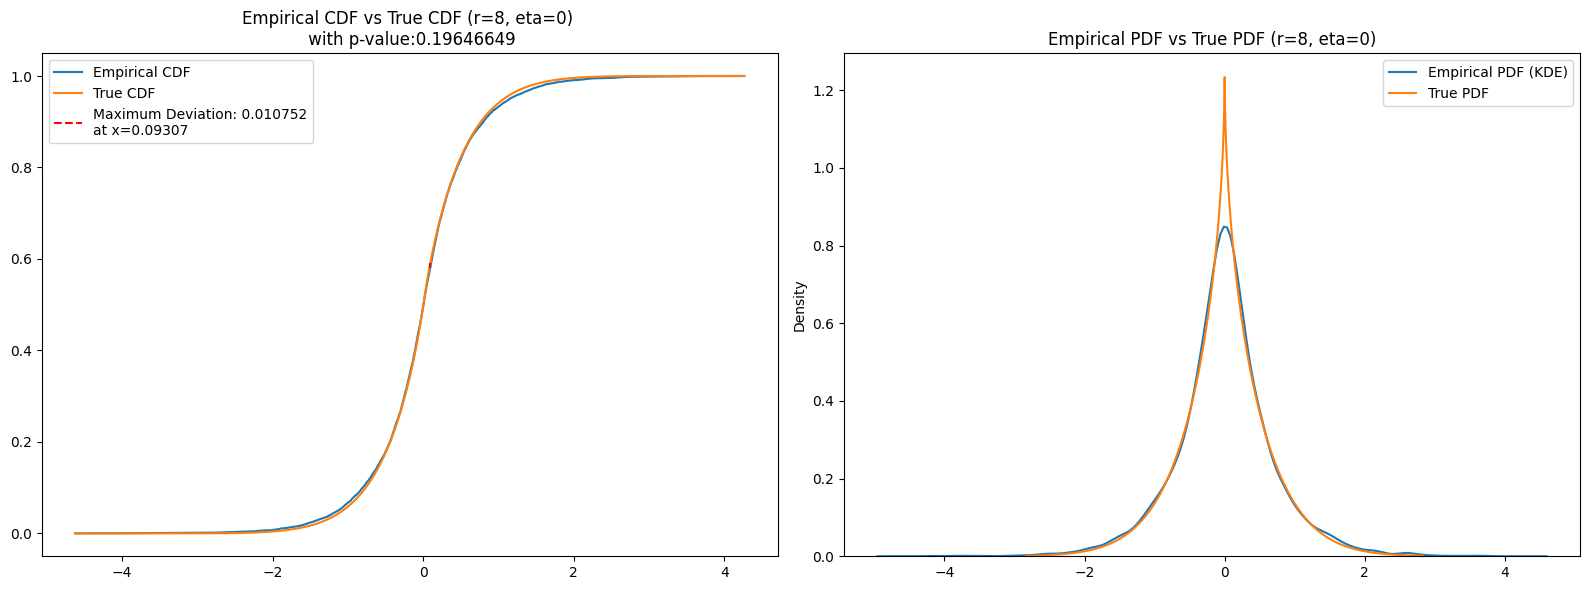

(0.010752403541787081, 0.09306973153566842)

In [6]:
visualize_cdf_pdf(sorted(scipy.stats.laplace(scale=0.5).rvs(size=1000000)), (8, 0), all_cdfs = all_cdfs)

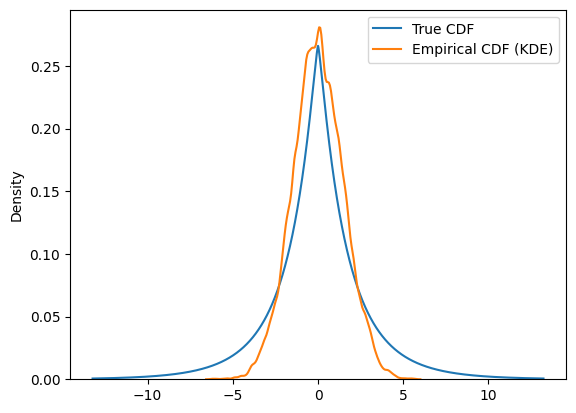

In [ ]:
# Note that this is with KDEs, subjective element with bandwidth parameter, but I think conveys the idea well
xs, pdf = compute_prior_pdf(1, 1)
cdf = all_cdfs[(1,1)]
plt.plot(xs, pdf, label = 'True CDF')
sns.kdeplot(sorted(scipy.stats.norm(scale=1.5).rvs(size=10000)), label = 'Empirical CDF (KDE)', bw_adjust = 0.5)

plt.legend()

In [53]:
def generate_func(sample, distro, *args):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale = var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale = var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'gengamma_r':
        eta = args[0]
        def r_func(r):
            print(r, eta)
            cache = pd.read_pickle('CDFs/optimize_cache.pickle')
            if (r, eta) in cache:
                cdf = cache[(r, eta)]
                return compute_ksstat(sample, cdf)
            else:
                cdf = compute_prior_cdf(r, eta, 10000)
            cache[(r, eta)] = cdf
            pd.to_pickle(cache, "CDFs/optimize_cache.pickle")
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'gengamma_eta':
        r = args[0]
        def eta_func(eta):
            print(r, eta)
            cache = pd.read_pickle('CDFs/optimize_cache.pickle')
            if (r, eta) in cache:
                cdf = cache[(r, eta)]
                return compute_ksstat(sample, cdf)
            else:
                cdf = compute_prior_cdf(r, eta, 10000)
            cache[(r, eta)] = cdf
            pd.to_pickle(cache, "CDFs/optimize_cache.pickle")
            return compute_ksstat(sample, cdf)
        return eta_func
    print("Please enter a valid argument for `distro` : 'gaussian', 'laplace', 'gengamma_r', 'gengamma_eta'")

In [60]:
def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']
    print(find_r_2['fun'])

    return r_2, eta_1, find_r_2['fun']

for layer in np.arange(2, 9):
    master_df.loc[layer, f'best_r_scipy'], master_df.loc[layer, f'best_eta_scipy'], master_df.loc[layer, f'kstest_stat_cd_scipy'] = coord_descent_scipy(obs_x_dict[layer], master_df.loc[layer, 'initial_param'])


0.576393202250021 3.2
0.623606797749979 3.2
0.652786404500042 3.2
0.6031885922970331 3.2
0.6012130721760752 3.2
0.5917327254606739 3.2
0.5995263745882929 3.2
0.6012819496325578 3.2
0.6008072545764275 3.2
0.6010580636462427 3.2
0.6010966252403329 3.2
0.6011245896439803 3.2
0.6011178803820277 3.2
0.601112378777304 3.2
0.601106361461624 3.2
0.601112378777304 3.176393202250021
0.601112378777304 3.223606797749979
0.601112378777304 3.2527864045000423
0.601112378777304 3.2022432820870237
0.601112378777304 3.200762311041007
0.601112378777304 3.191454139758394
0.601112378777304 3.1987356403894647
0.601112378777304 3.2001759405658374
0.601112378777304 3.1999241571766412
0.601112378777304 3.1997970135807843
0.601112378777304 3.200002340153232
0.601112378777304 3.2000263144268573
0.601112378777304 3.1999881390010834
0.601112378777304 3.1999989593561935
0.601112378777304 3.1999955785592054
0.577505581027325 3.1999989593561935
0.6247191765272829 3.1999989593561935
0.653898783277346 3.199998959356193

In [65]:
for layer in np.arange(2, 9):
    norm_result = scipy.optimize.minimize_scalar(generate_func(obs_x_dict[layer], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(obs_x_dict[layer], 'laplace'), method = 'bounded', bounds = (0, 50))
    master_df.loc[layer, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[layer, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[layer, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[layer, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)

master_df.to_csv(f'panoptic/CSVs/master_df.csv')
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0,kstest_stat_cutoff_0.05,best_r_d3,best_eta_d2,kstest_stat_cd,n_pval_0.05,best_r_scipy,best_eta_scipy,kstest_stat_cd_scipy,param_gaussian,kstest_stat_gaussian,param_laplace,kstest_stat_laplace
layer,,,,,,,,,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.024030,0.602,3.20,0.036033,1341,0.601112,3.199999,0.035572,27.782300,0.019503,25.439100,0.036392
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.012029,0.705,3.60,0.019860,4770,0.697533,3.499982,0.018549,16.031400,0.010128,14.012900,0.022665
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.006018,0.803,3.00,0.010449,16098,0.801302,2.999992,0.009863,8.001070,0.020474,7.104980,0.014498
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.003010,0.901,1.60,0.003043,203520,0.899117,1.600006,0.003011,3.590120,0.030175,3.138820,0.002343
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,0.001505,1.030,0.33,0.003707,128142,1.105179,0.500005,0.005470,1.426170,0.042370,1.246790,0.014477
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,0.000753,4.630,0.00,0.024879,3016,4.499935,0.002368,0.024973,0.539642,0.052925,0.472750,0.025277
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,0.000376,5.700,0.00,0.171259,60,5.651842,0.000007,0.171067,0.196018,0.056353,0.172564,0.029150


In [94]:
master_df.filter(regex='num_samples|kstest_stat.*').values
#.apply(lambda x : print(x.index))#stats.kstwo(n=obs_x_dict[x]).sf(x))
#.to_csv('panoptic/CSVs/kstest_stats.csv')

array([[3.18000000e+03, 3.83401478e-02, 1.02708811e-01, 2.40303355e-02,
        3.60334474e-02, 3.55717445e-02, 1.95034000e-02, 3.63916000e-02],
       [1.27200000e+04, 2.02302374e-02, 1.06738953e-01, 1.20285145e-02,
        1.98597460e-02, 1.85491944e-02, 1.01280000e-02, 2.26653000e-02],
       [5.08800000e+04, 1.16656130e-02, 6.10779225e-02, 6.01756350e-03,
        1.04490773e-02, 9.86281963e-03, 2.04744000e-02, 1.44979000e-02],
       [2.03520000e+05, 3.22473744e-03, 4.03012349e-02, 3.00960449e-03,
        3.04341729e-03, 3.01064224e-03, 3.01747000e-02, 2.34302000e-03],
       [8.14080000e+05, 6.84383737e-03, 1.43695685e-02, 1.50500746e-03,
        3.70674135e-03, 5.47035801e-03, 4.23696000e-02, 1.44771000e-02],
       [3.25632000e+06, 2.48948284e-02, 2.48948284e-02, 7.52554970e-04,
        2.48788039e-02, 2.49729647e-02, 5.29250000e-02, 2.52765000e-02],
       [1.30252800e+07, 1.71258904e-01, 1.71258904e-01, 3.76290288e-04,
        1.71258904e-01, 1.71067206e-01, 5.63528000e-02, 2.

In [71]:
cdfs = pd.read_pickle('CDFs/optimize_cache.pickle')
compute_ksstat(obs_x_dict[5], compute_prior_cdf(0.899117, 1.600006))

No Tail


0.0030106527416742246

In [ ]:
%%time
# Creates validation dataframes 
# For now, it caps out at 6. For layer 7 and up it just defaults to 2.9, 0

# for layer in range(6, 8):
#     obs_x = create_obs_x(data_dict, layer)
#     df = make_layer_df(obs_x, all_cdfs_df)
#     total_samples = obs_x.size
#     all_num_samples = np.sort(np.append(5*10**np.arange(3.0, np.floor(np.log10(total_samples))), 10**np.arange(3.0, np.ceil(np.log10(total_samples)))))
#     print(list(all_num_samples))
#     np.random.seed(42)
#     x = obs_x[np.random.permutation(total_samples)]
#     val_df = pd.concat([val_df_fixed_num(x, n, all_cdfs_df) for n in all_num_samples])
#     val_df.to_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv')
#     val_df.value_counts(['r', 'eta'])

In [ ]:
val_df = pd.read_csv(f'panoptic/CSVs/val_df{4}.csv', index_col='Unnamed: 0')
print(val_df.value_counts(['r', 'eta'])[:10])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots

for layer in np.arange(layer, layer+1):
    #obs_x = obs_x_dict[layer]
    #df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv', index_col='Unnamed: 0')

    # Scatter plot
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax1)
    r, eta = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    ax1.scatter(x=r, y=eta, marker="*", label='all_data', s=60, color='xkcd:shamrock green', alpha=0.7)
    ax1.set_title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    ax1.legend()

    # KDE plot
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
np.random.seed(42)

# TODO: Put plots side by side
for layer in np.arange(layer, layer+1):
    obs_x = obs_x_dict[layer]
    df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
    plt.title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    plt.legend()
    
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    

In [ ]:
layer = 6
val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
mask = val_df['num_samples'] == 100
sns.kdeplot(val_df.drop(['kstest_pval'], axis = 1)[mask], x = 'r', y = 'eta', fill=True)
r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
plt.title('Validation')